# Support Vector Machines: College Admission

Let's look at a classification example in Spark MLLib.  We looked at the college admission before. We can look again at this dataset.  


In [73]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 executor.memory=2g
	some_property=some_value
	spark.app.name=TestApp
	spark.master=local[*]
	spark.sql.warehouse.dir=/tmp/tmp4hjkg3iv
	spark.submit.deployMode=client
	spark.ui.showConsoleProgress=true
Spark UI running on port 4045


## Step 1: Load the data

In [74]:
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", header=True, inferSchema=True)
dataset.printSchema()
dataset.show(20)

root
 |-- admit: integer (nullable = true)
 |-- gre: integer (nullable = true)
 |-- gpa: double (nullable = true)
 |-- rank: integer (nullable = true)

+-----+---+----+----+
|admit|gre| gpa|rank|
+-----+---+----+----+
|    0|380|3.61|   3|
|    1|660|3.67|   3|
|    1|800| 4.0|   1|
|    0|640|3.19|   4|
|    0|520|2.93|   4|
|    1|760| 3.0|   2|
|    0|560|2.98|   1|
|    0|400|3.08|   2|
|    0|540|3.39|   3|
|    1|700|3.92|   2|
|    1|800| 4.0|   4|
|    0|440|3.22|   1|
|    1|760| 4.0|   1|
|    1|700|3.08|   2|
|    1|700| 4.0|   1|
|    0|480|3.44|   3|
|    1|780|3.87|   4|
|    0|360|2.56|   3|
|    1|800|3.75|   2|
|    0|540|3.81|   1|
+-----+---+----+----+
only showing top 20 rows



## Step 2 - Data Exploration

In [75]:
# use describe
dataset.describe().toPandas()

,summary,admit,gre,gpa,rank
0,count,100,100,100,100
1,mean,0.43,600.0,3.390699999999998,2.52
2,stddev,0.49756985195624304,124.46248065545332,0.3971877275408833,1.019803902718557
3,min,0,300,2.42,1
4,max,1,800,4.0,4


In [76]:
# see data spread
dataset.groupBy("admit").count().show()

+-----+-----+
|admit|count|
+-----+-----+
|    1|   43|
|    0|   57|
+-----+-----+



## Step 3: Build the Vector

In [77]:
from pyspark.ml.feature import VectorAssembler

## TODO : input cols : gre, gpa, rank

assembler = VectorAssembler(inputCols=['gre', 'gpa', 'rank'], outputCol="features")
featureVector = assembler.transform(dataset)
featureVector = featureVector.withColumn("label", featureVector["admit"])
featureVector.sample(False, 0.1, seed=10).show(50)

+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|640|3.19|   4|[640.0,3.19,4.0]|    0|
|    0|360|2.56|   3|[360.0,2.56,3.0]|    0|
|    0|520| 2.9|   3| [520.0,2.9,3.0]|    0|
|    0|660|3.34|   3|[660.0,3.34,3.0]|    0|
|    1|800|3.73|   1|[800.0,3.73,1.0]|    1|
|    0|480|3.39|   4|[480.0,3.39,4.0]|    0|
|    0|580| 4.0|   2| [580.0,4.0,2.0]|    0|
|    1|500| 3.6|   3| [500.0,3.6,3.0]|    1|
+-----+---+----+----+----------------+-----+



## Step 4: Split into training and test.

In [78]:
## Split into training and test
## TODO: create training and test with an 80/20 split
(training, test) = featureVector.randomSplit([0.8, 0.2])

print ("training set count ", training.count())
print ("testing set count ", test.count())

training set count  81
testing set count  19


## Step 5: Build the Linear SVM model

In [79]:
from pyspark.ml.classification import LinearSVC

## TODO : set MaxIter to 10
lsvc = LinearSVC(maxIter=100, regParam=0.3)

In [80]:
%%time

# Fit the model
## TODO : fit on 'training' set
print ("training starting...")
lsvcModel = lsvc.fit(training)
print("training done.")

training starting...
training done.
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.71 s


In [81]:
# Print the coefficients and intercept for linearsSVC
print ("inputs : gre, gpa, rank")
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

inputs : gre, gpa, rank
Coefficients: [0.0038702344656304007,1.077677265102832,-0.12268785431247]
Intercept: -5.916145249988966


### Adjust Iterations

If any coefficient is zero, that variable won't be a factor in the decision !  
Set **maxIter=50**  and try again

## Step 6: Run the test set and get the predictions

In [82]:
# ## TODO: transform the test data
# ## HINT : test
# predictions_test = lsvcModel.transform(test)
# predictions_test.show()

# ## sample
# predictions_test.sampleBy("label", fractions={0: 0.5, 1: 0.5}, seed=0).show()
predictions_test = lsvcModel.transform(test)
predictions_train = lsvcModel.transform(training)
predictions_test.sample(False, 0.2).show(50)

+-----+---+----+----+----------------+-----+--------------------+----------+
|admit|gre| gpa|rank|        features|label|       rawPrediction|prediction|
+-----+---+----+----+----------------+-----+--------------------+----------+
|    1|780|3.22|   2|[780.0,3.22,2.0]|    1|[-0.3273827182089...|       1.0|
+-----+---+----+----+----------------+-----+--------------------+----------+



## Step 7: See the evaluation metrics

In [83]:
predictions_test = lsvcModel.transform(test)  # Hint : test
predictions_train = lsvcModel.transform(training)  # Hint : training

### 7.1 - Accuracy

**TODO: Compare 'training' & 'test' set accuracies**  
Can you detect any overfitting / underfitting?


**TODO: Increase 'maxIterations' and try again**  
Does the accuracy go up?  

In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

print("Training accuracy :",  evaluator.evaluate(predictions_train))
print("Test accuracy :",  evaluator.evaluate(predictions_test))

Training accuracy : 0.7901234567901234
Test accuracy : 0.8421052631578947


###  7.2 - Confusion matrix

In [85]:
# Confusion matrix
cm = predictions_test.groupBy('label').pivot('prediction', [0,1]).count().na.fill(0).orderBy('label')
cm.show()

+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    0| 11|  1|
|    1|  2|  5|
+-----+---+---+



[]

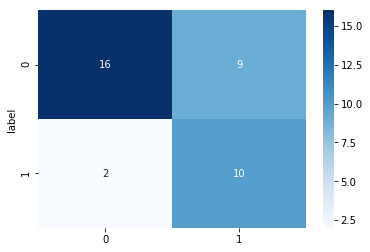

In [46]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("label", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, cmap="Blues").plot()

### 7.3 - AUC
**=> What does AUC mean?** 

In [86]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# default metrics for BinaryClassificationEvaluator is 'areaUnderCurve'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# print ("default metrics : " ,evaluator.getMetricName())

print("AUC for training: " , evaluator.evaluate(predictions_train))
print ("AUC for test : " , evaluator.evaluate(predictions_test))

AUC for training:  0.8666666666666664
AUC for test :  0.9047619047619048


## Step 8: Try running a prediction on your own data

In [87]:
import pandas as pd

newdata = pd.DataFrame({'gre' : [600, 700, 800], 
                        'gpa' : [4.0, 3.5, 3.2],
                        'rank': [1,   2,   3]}
             )
print(newdata)

## TODO : create a spark dataframe
## Hint : input is 'newdata'
spark_newdata = spark.createDataFrame(newdata)

## TODO : create feature vector
## Hint : spark_newdata
newfeatures = assembler.transform(spark_newdata)

lsvcModel.transform(newfeatures).show()

   gre  gpa  rank
0  600  4.0     1
1  700  3.5     2
2  800  3.2     3
+---+---+----+---------------+--------------------+----------+
|gre|gpa|rank|       features|       rawPrediction|prediction|
+---+---+----+---------------+--------------------+----------+
|600|4.0|   1|[600.0,4.0,1.0]|[-0.5940166354881...|       1.0|
|700|3.5|   2|[700.0,3.5,2.0]|[-0.3195135951872...|       1.0|
|800|3.2|   3|[800.0,3.2,3.0]|[-0.2605460079070...|       1.0|
+---+---+----+---------------+--------------------+----------+



## Step 9 : Understanding the impact of Scaling Data
Just now we have fed our input vector without scaling to SVM.  
IN this section we are going to scale the data and see if it improves the prediction.  
We will condense the code to focus on important stuff

### 9.1 : Raw data (without scaling)

In [88]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC


print ("===== run with raw data (not scaled) =======")
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", \
                         header=True, inferSchema=True)
assembler = VectorAssembler(inputCols=[ 'gre', 'gpa', 'rank'], outputCol="features")
featureVector = assembler.transform(dataset)
featureVector = featureVector.withColumn("label", featureVector["admit"])
(training, test) = featureVector.randomSplit([0.8, 0.2], seed=123)
lsvc = LinearSVC(maxIter=100, regParam=0.3, featuresCol='features')
lsvcModel = lsvc.fit(training)
print ("inputs :  gre, gpa, rank")
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

predictions_train = lsvcModel.transform(training)
predictions_test = lsvcModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print ("Training AUC : " , evaluator.evaluate(predictions_train))
print ("Test AUC : " , evaluator.evaluate(predictions_test))  #AUC

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Training accuracy",  evaluator.evaluate(predictions_train))
print("Testing accuracy",  evaluator.evaluate(predictions_test))
print ("===== END run with raw data (not scaled) =======")

===== run with raw data (not scaled) =======
inputs :  gre, gpa, rank
Coefficients: [0.004471158074653798,1.2161147145938713,-0.08283634499589466]
Intercept: -6.953627550839707
Training AUC :  0.8856951871657758
Test AUC :  0.8376068376068375
Training accuracy 0.7948717948717948
Testing accuracy 0.8181818181818182
===== END run with raw data (not scaled) =======


### 9.2 : Scaled data

In [89]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import StandardScaler

print ("===== run with scaled data  =======")
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", \
                         header=True, inferSchema=True)
assembler = VectorAssembler(inputCols=[ 'gre', 'gpa', 'rank'], outputCol="features")
featureVector = assembler.transform(dataset)
featureVector = featureVector.withColumn("label", featureVector["admit"])

# scaling
scaler = StandardScaler(inputCol="features", outputCol="featuresScaled",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(featureVector)
fv_scaled = scalerModel.transform(featureVector)
fv_scaled.show(20, truncate=False)

(training, test) = fv_scaled.randomSplit([0.8, 0.2], seed=123)  ## CHANGED
lsvc = LinearSVC(maxIter=100, regParam=0.3, featuresCol='featuresScaled')  ## CHANGED

lsvcModel = lsvc.fit(training)
print ("inputs :  gre, gpa, rank")
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

predictions_train = lsvcModel.transform(training)
predictions_test = lsvcModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print ("Training AUC : " , evaluator.evaluate(predictions_train))
print ("Test AUC : " , evaluator.evaluate(predictions_test))  #AUC


evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

print("Training accuracy",  evaluator.evaluate(predictions_train))
print("Testing accuracy",  evaluator.evaluate(predictions_test))

print ("===== END run with scaled data =======")


===== run with scaled data  =======
+-----+---+----+----+----------------+-----+---------------------------------------------------------+
|admit|gre|gpa |rank|features        |label|featuresScaled                                           |
+-----+---+----+----+----------------+-----+---------------------------------------------------------+
|0    |380|3.61|3   |[380.0,3.61,3.0]|0    |[3.05312892687673,9.088901166082522,2.9417420270727606]  |
|1    |660|3.67|3   |[660.0,3.67,3.0]|1    |[5.302802872996426,9.23996323532489,2.9417420270727606]  |
|1    |800|4.0 |1   |[800.0,4.0,1.0] |1    |[6.427639846056274,10.070804616157918,0.9805806756909201]|
|0    |640|3.19|4   |[640.0,3.19,4.0]|0    |[5.14211187684502,8.03146668138594,3.9223227027636804]   |
|0    |520|2.93|4   |[520.0,2.93,4.0]|0    |[4.177965899936578,7.376864381335675,3.9223227027636804] |
|1    |760|3.0 |2   |[760.0,3.0,2.0] |1    |[6.10625785375346,7.553103462118439,1.9611613513818402]  |
|0    |560|2.98|1   |[560.0,2.98,1.0]

## Step 10 : Discuss the findings

### Coefficients
Here are the coefficients from one sample run

raw data run : 
inputs :  gre, gpa, rank
Coefficients: [0.00730924862823,0.803788881405,-0.182571791707]
Intercept: -7.016411699283878

scaled data run:
inputs :  gre, gpa, rank
Coefficients: [0.985025239033,0.311565356517,-0.180265498388]
Intercept: -7.500693768967119

### Accuracy
Compare accuracies